In [1]:
# Importing required libraries

import json
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('vader_lexicon')
from wordcloud import WordCloud
import re
from collections import Counter


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Loading the data

file = open("data.json","r")

data = json.load(file)

data_df = pd.DataFrame(data, columns=['user_id','log_time','description'])

#724 rows x 3cols

In [3]:
# Converting string to datetime
data_df['log_time'] = pd.to_datetime(data_df['log_time'])

# Adding columns for date, time, month and hour for each record
data_df['date'] = data_df['log_time'].dt.date
data_df['time'] = data_df['log_time'].dt.time
data_df['hour'] = data_df['log_time'].dt.hour
data_df['month'] = data_df['log_time'].dt.month


In [4]:
# Splitting description, convert to lowercase into words and remove stopwords
data_df['description'] = list(map(lambda desc: desc.lower(), data_df['description']))

def remove_stopwords(desc):
    sw = set(stopwords.words('english'))
    sw.update(["plate","bowl","spoon","fork","table","cup","kitchen"])
    final_words = [word for word in desc.split() if word.lower() not in sw]
    return ' '.join(final_words)

data_df['new_desc'] = data_df['description'].apply(remove_stopwords)
wc = ' '.join(desc for desc in data_df['new_desc'])
data_df['new_desc'] = list(map(lambda desc: desc.split(), data_df['new_desc']))


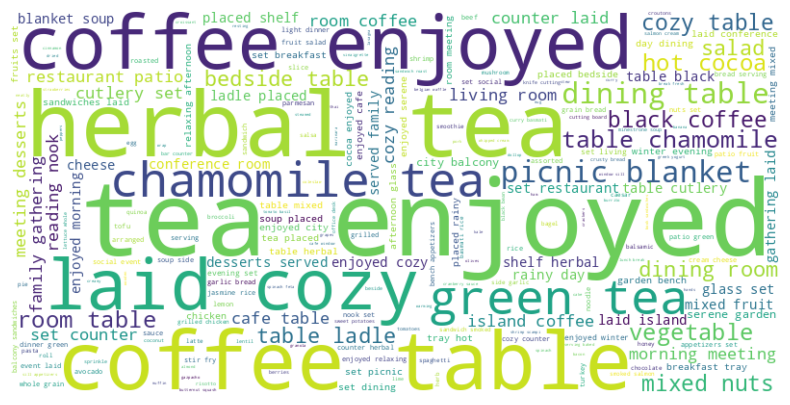

In [5]:
# WordCloud to display the most frequent words using matplotlib

unique_wc = set()

for desc in data_df['new_desc']:
  for word in desc:
    unique_wc.add(word)

wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=(len(unique_wc))).generate(wc)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [6]:
# Extracting words related only to food but not to cultery

def is_food_related(word):
    synsets = wordnet.synsets(word)
    food = False
    cutlery = False
    for synset in synsets:
        if 'food' in synset.definition().lower():
          food = True
        if 'cutlery' in synset.definition().lower():
          cutlery = True

    return food and not(cutlery)

food_related_words = []
for desc in data_df['new_desc']:
  for word in desc:
    if is_food_related(word):
      food_related_words.append(word)


frwstr = ' '.join(food_related_words)
frws = set(food_related_words)



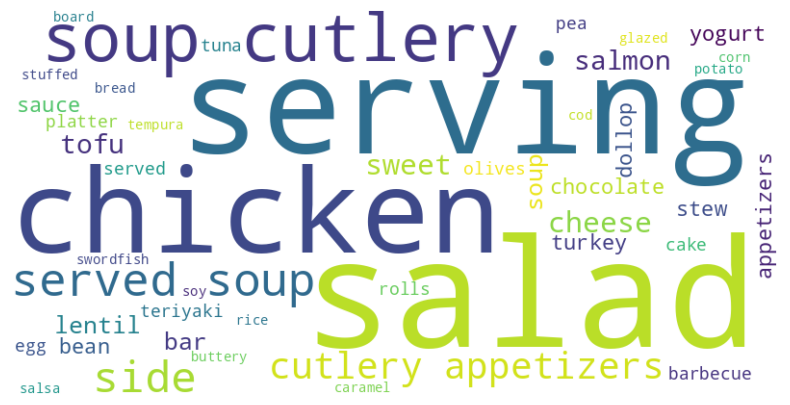

In [7]:
# WordCloud to show only the food-related words

wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=(len(frws))).generate(frwstr)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels
plt.show()

In [8]:
# Printing the most frequent words

words = re.findall(r'\b\w+\b', frwstr.lower())

word_counts = Counter(words)

for word, count in word_counts.most_common(5):  #top five
    print(f"{word}: {count} times")

soup: 40 times
salad: 29 times
cutlery: 25 times
serving: 23 times
chicken: 20 times


In [19]:
# Categorizing every entry as Breakfast, Lunch or Dinner

def categorize_meal(hr):
    if 4 <= hr < 11:
        return 'breakfast'
    elif 11 <= hr < 18:
        return 'lunch'
    else:
        return 'dinner'

data_df['meal_type'] = data_df['hour'].apply(categorize_meal)

meal_types = ['breakfast', 'lunch', 'dinner']
for meal in meal_types:
    meal_df = data_df[data_df['meal_type'] == meal]
    print(meal+" logs:")
    print(meal_df['hour'].value_counts().sort_index())

breakfast logs:
4     14
5      9
6     10
7     13
8     14
9     25
10    20
Name: hour, dtype: int64
lunch logs:
11    22
12    28
13    29
14    39
15    39
16    44
17    47
Name: hour, dtype: int64
dinner logs:
0     25
1     21
2     19
3     25
18    58
19    53
20    55
21    48
22    34
23    33
Name: hour, dtype: int64


In [10]:
# Sentiment analysis to understand how the user feels while giving the a particular meal entry

def get_happiness_score(desc):
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = sid.polarity_scores(desc)
    return sentiment_scores['compound']

def rank_entries(df):
    df['SentimentScore'] = df['description'].apply(lambda x: get_happiness_score(x))
    df = df.sort_values(by='SentimentScore', ascending=False).reset_index(drop=True)
    df['Rank'] = df.index + 1
    return df[['description', 'Rank','SentimentScore', 'user_id', 'date','meal_type']]


ranked_df = rank_entries(data_df)

positive_sentiment = ranked_df[ranked_df['SentimentScore'] >= 0]
print(positive_sentiment)

negative_sentiment = ranked_df[ranked_df['SentimentScore'] < 0]
print(negative_sentiment)



                                           description  Rank  SentimentScore  \
0    a cup of herbal tea enjoyed during a relaxing ...     1          0.7579   
1    a cup of chamomile tea enjoyed during a relaxi...     2          0.7579   
2    a cup of herbal tea enjoyed during a relaxing ...     3          0.7579   
3    a cup of herbal tea enjoyed during a relaxing ...     4          0.7579   
4    a cup of herbal tea enjoyed during a relaxing ...     5          0.7579   
..                                                 ...   ...             ...   
673      a bowl and a ladle placed on a kitchen shelf.   674          0.0000   
674      a bowl and a ladle placed on a kitchen shelf.   675          0.0000   
675      a plate and cutlery set on a kitchen counter.   676          0.0000   
676  a bowl and spoon laid out on a cozy kitchen ta...   677          0.0000   
677          a plate and a glass set on a bar counter.   678          0.0000   

    user_id        date meal_type  
0  

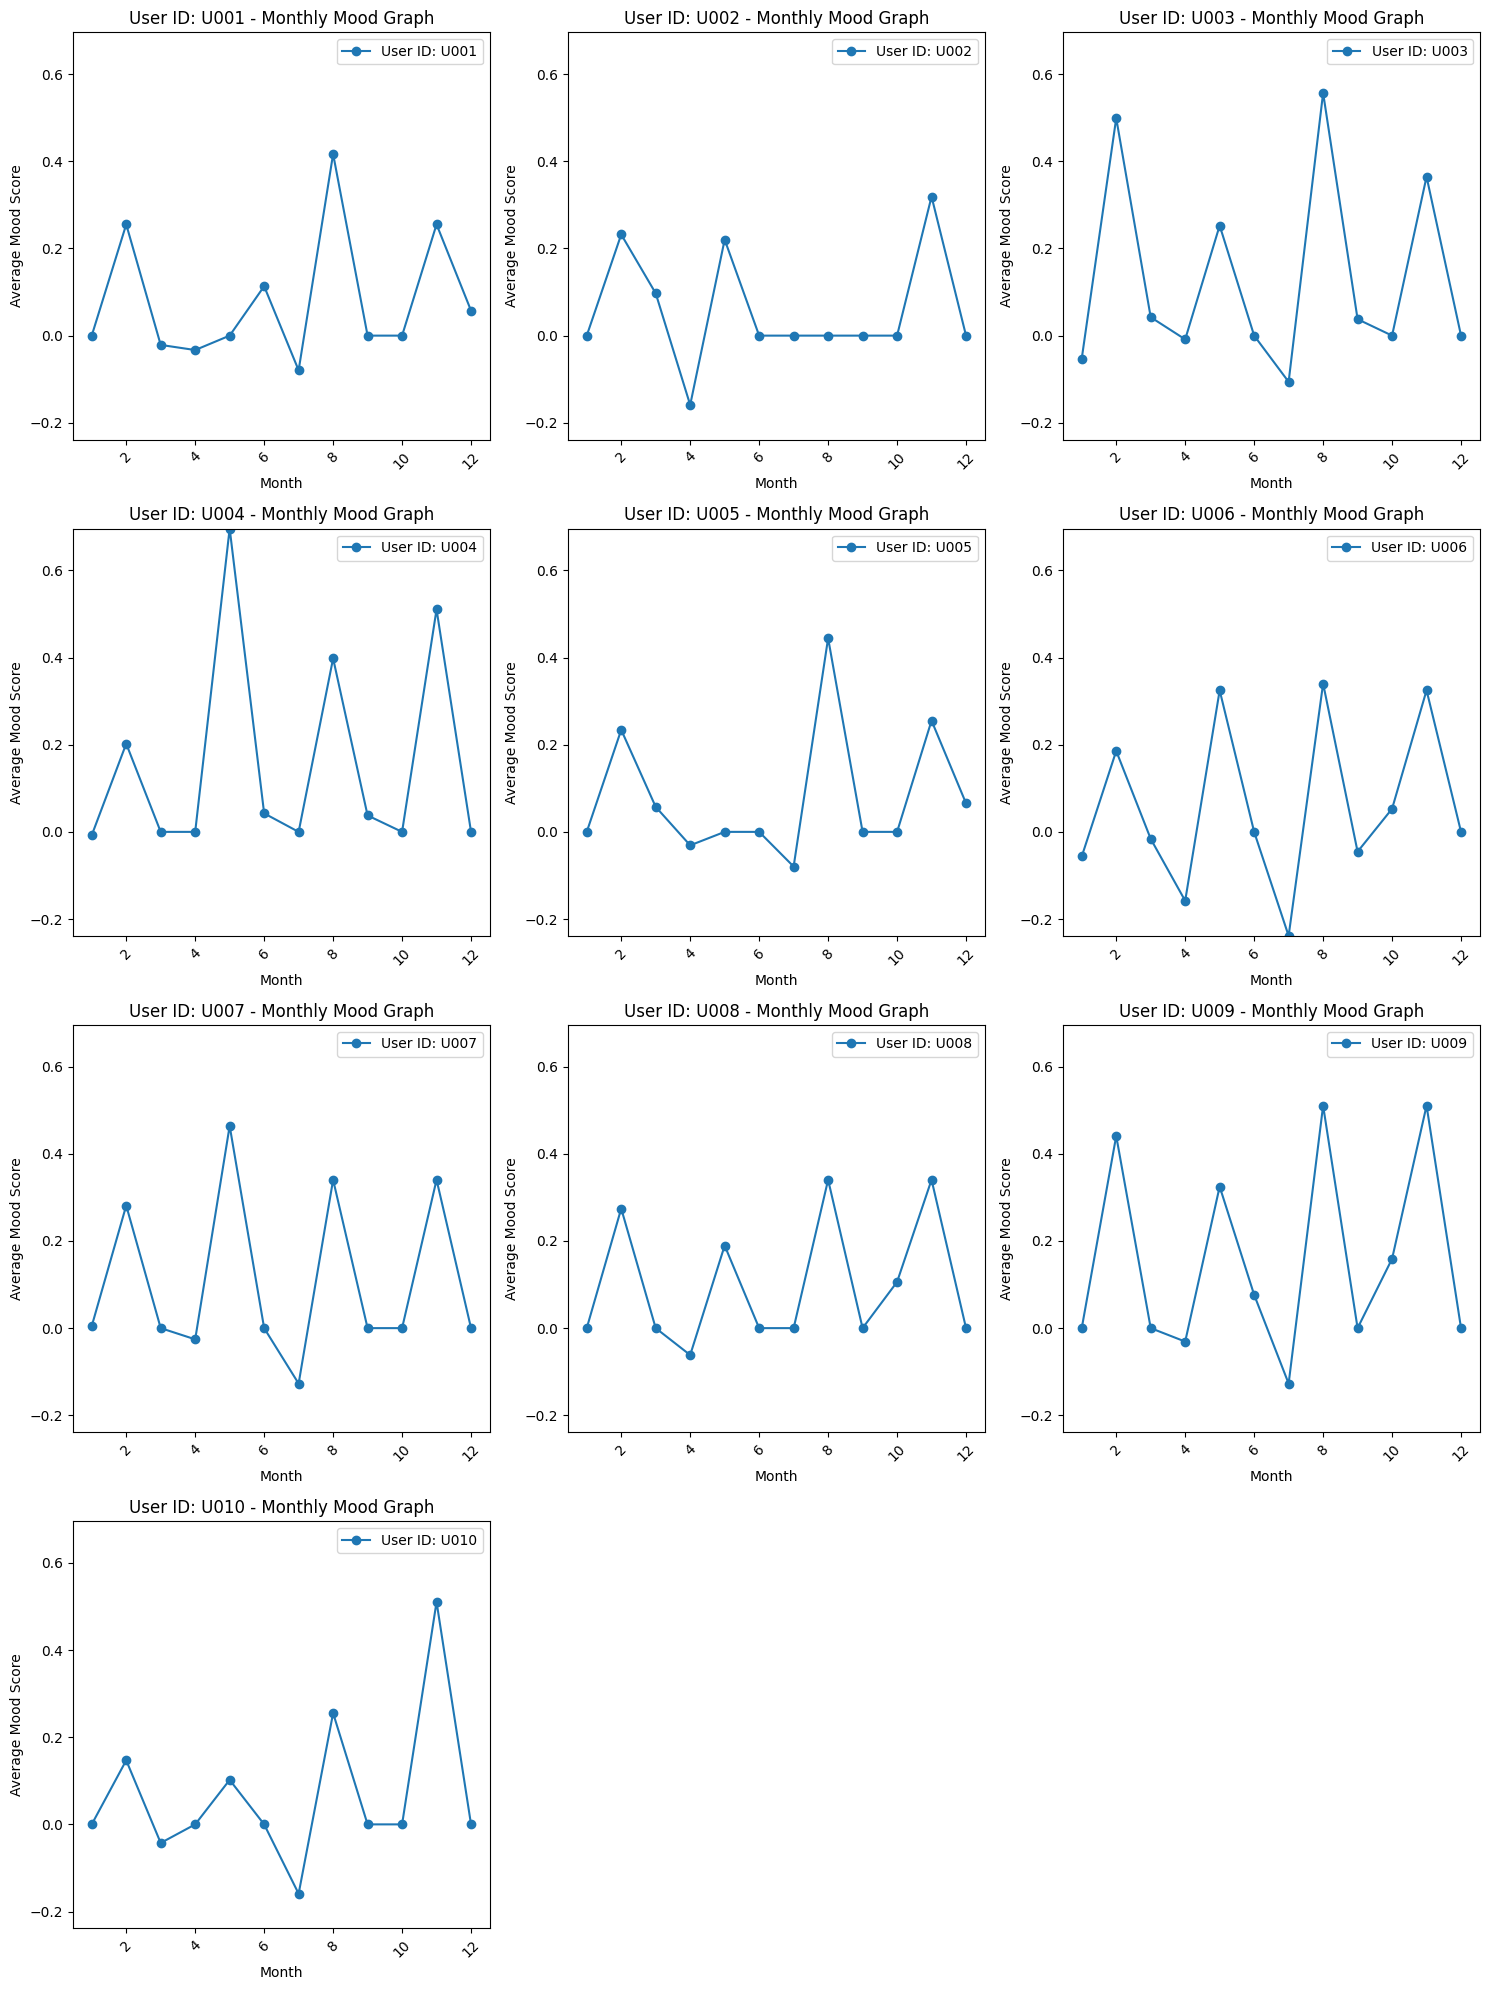

In [11]:
# Calculating monthly average Mood Score for each user
ranked_df['month'] = pd.to_datetime(ranked_df['date']).dt.month

monthly_avg_mood = ranked_df.groupby(['user_id', 'month'])['SentimentScore'].mean().reset_index()

# Plot monthly average Mood Score for each user
users = monthly_avg_mood['user_id'].unique()
num_users = len(users)
num_cols = 3
num_rows = -(-num_users // num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

# Scaling the Y-Axis
y_min = monthly_avg_mood['SentimentScore'].min()
y_max = monthly_avg_mood['SentimentScore'].max()



for idx, user_id in enumerate(users):
    row = idx // num_cols
    col = idx % num_cols

    user_data = monthly_avg_mood[monthly_avg_mood['user_id'] == user_id]
    axes[row, col].plot(user_data['month'], user_data['SentimentScore'], marker='o', linestyle='-', label=f'User ID: {user_id}')
    axes[row, col].set_title(f'User ID: {user_id} - Monthly Mood Graph')
    axes[row, col].set_xlabel('Month')
    axes[row, col].set_ylabel('Average Mood Score')
    axes[row, col].tick_params(axis='x', rotation=45)
    axes[row, col].set_ylim(y_min, y_max)
    axes[row, col].legend()

# Hide empty subplots if the number of users doesn't fill the entire grid
for idx in range(num_users, num_rows * num_cols):
    row = idx // num_cols
    col = idx % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


In [12]:
# Finding user's favorite meal type based on Sentiment Score

# Finding the average meal type sentiment for each meal type for each user
meals_avg_sentiment = ranked_df.groupby(['user_id', 'meal_type'])['SentimentScore'].mean().reset_index()
max_sentiment_index = meals_avg_sentiment.groupby('user_id')['SentimentScore'].idxmax()
max_sentiment_meal_type = meals_avg_sentiment.loc[max_sentiment_index, ['user_id', 'meal_type', 'SentimentScore']]

print("Favorite Meal type for each user:")
print(max_sentiment_meal_type)

Favorite Meal type for each user:
   user_id  meal_type  SentimentScore
2     U001      lunch        0.109117
4     U002     dinner        0.126234
6     U003  breakfast        0.110263
11    U004      lunch        0.157880
12    U005  breakfast        0.142700
17    U006      lunch        0.118788
20    U007      lunch        0.134027
22    U008     dinner        0.157279
26    U009      lunch        0.239341
28    U010     dinner        0.074200


In [13]:
# Calculating daily user activity based on number of actions(logs) per day

user_activity = data_df.groupby(['user_id', 'date']).size().reset_index(name='actions_count')
user_activity_pivot = user_activity.pivot(index='date', columns='user_id', values='actions_count').fillna(0)


In [14]:
# Calculating monthly user activity based on number of actions(logs) per day

monthly_user_activity = data_df.groupby(['user_id', 'month']).size().reset_index(name='actions_count')
monthly_user_activity_pivot = monthly_user_activity.pivot(index='month', columns='user_id', values='actions_count').fillna(0)


    user_id  month  actions_count
0      U001      1              6
1      U001      2              6
2      U001      3              6
3      U001      4              7
4      U001      5              2
..      ...    ...            ...
115    U010      8             12
116    U010      9              5
117    U010     10              6
118    U010     11              1
119    U010     12              5

[120 rows x 3 columns]


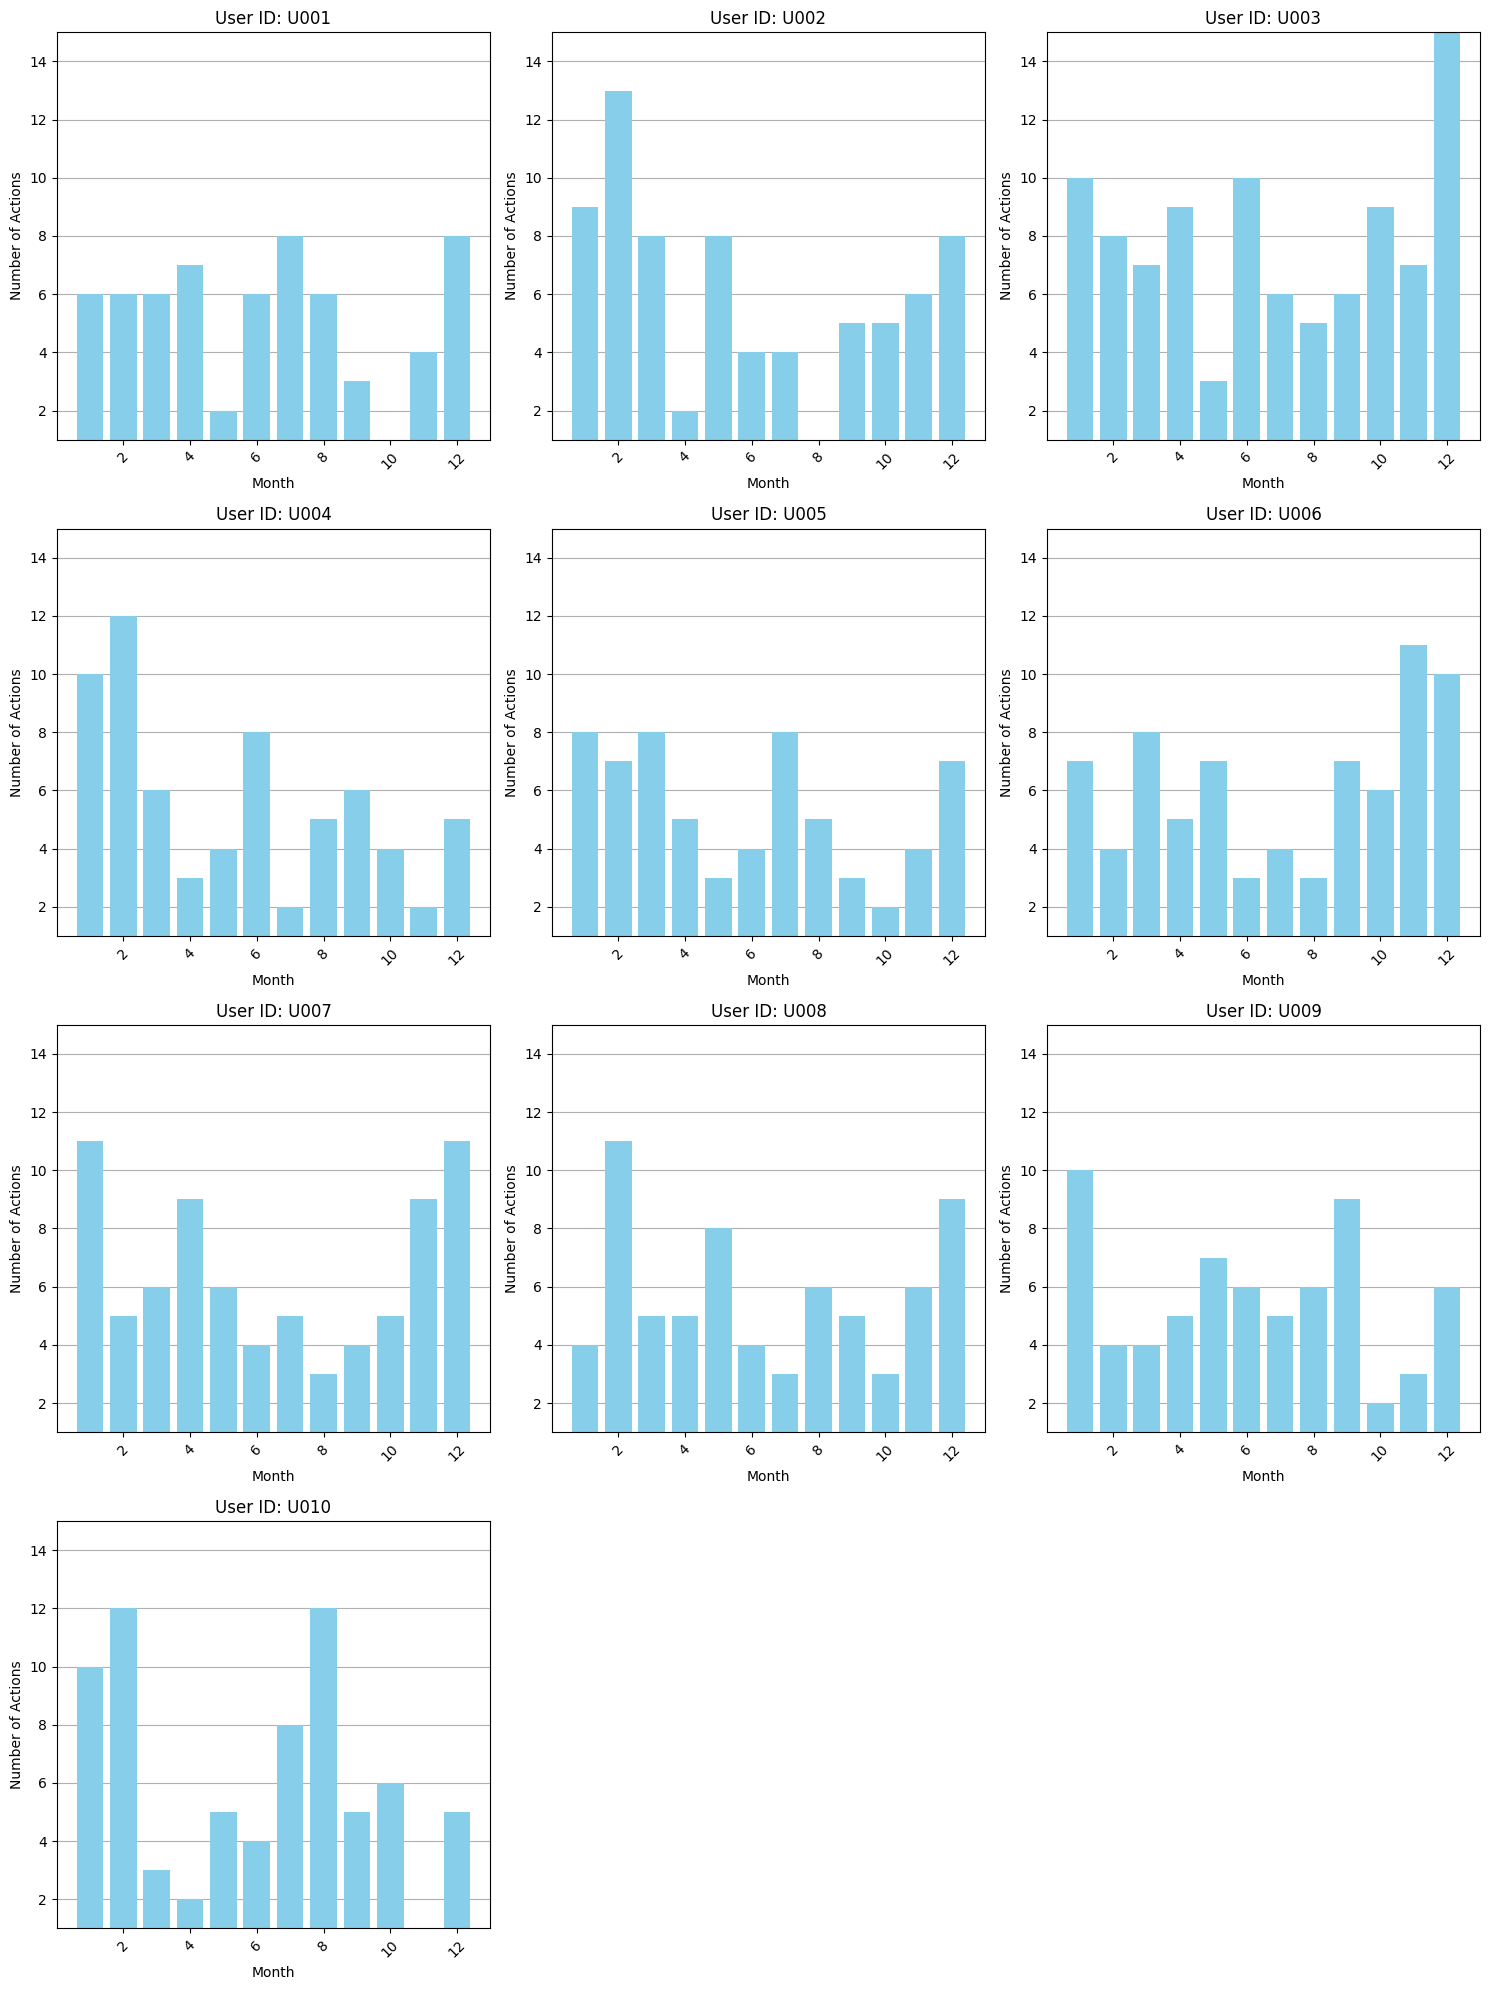

In [15]:
# Plotting Monthly User Activity Graph

all_users = monthly_user_activity_pivot.columns.tolist()

num_users = len(all_users)
num_cols = 3
num_rows = -(-num_users // num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

# Scaling the Y-Axis
y_min = monthly_user_activity_pivot.min().min()
y_max = monthly_user_activity_pivot.max().max()



# Plotting bar charts for monthly user activity in a grid with set y-axis limits
for idx, user_id in enumerate(all_users):
    row = idx // num_cols
    col = idx % num_cols
    user_activity = monthly_user_activity_pivot[user_id]
    axes[row, col].bar(user_activity.index, user_activity.values, color='skyblue')
    axes[row, col].set_title(f'User ID: {user_id}')
    axes[row, col].set_xlabel('Month')
    axes[row, col].set_ylabel('Number of Actions')
    axes[row, col].set_ylim(y_min, y_max)

    axes[row, col].tick_params(axis='x', rotation=45)
    axes[row, col].grid(axis='y')
    axes[row, col].set_axisbelow(True)


# Hide empty subplots if the number of users doesn't fill the entire grid
for idx in range(num_users, num_rows * num_cols):
    row = idx // num_cols
    col = idx % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()
